In [1]:
#loading base packages
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt

#loading keras packages
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Flatten

#loading sklearn packages
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report

Using TensorFlow backend.


In [2]:
#code to unpickle cifar 100 dataset and return dataframe
def unpickle_load_df(file):
    with open(file, 'rb') as fo:
        dict_ = pickle.load(fo, encoding='bytes')
        
    df=pd.DataFrame(dict_[ b'data'])
    columns=list(dict_.keys())
    columns.remove(b'data')
    for col in columns:
        df[col]=dict_[col]
        
    return df

In [3]:
#code to get index to label mapping
def get_index_to_label_mapping(type_):
    
    with open("cifar-100-python/meta", 'rb') as fo:
        dict_ = pickle.load(fo, encoding='bytes')
    
    idx2lbl=dict(enumerate(dict_[type_]))
    
    return idx2lbl

In [4]:
#loading train and test dataset
train=unpickle_load_df('cifar-100-python/train')
test=unpickle_load_df('cifar-100-python/test')
print(f"Train shape:{train.shape}")
print(f"Test shape:{test.shape}")

Train shape:(50000, 3076)
Test shape:(10000, 3076)


In [5]:
#in this tutorial we are going to use coarse labels 
idx2lbl=get_index_to_label_mapping(b'coarse_label_names') #b'fine_label_names' or b'coarse_label_names'
idx2lbl

{0: b'aquatic_mammals',
 1: b'fish',
 2: b'flowers',
 3: b'food_containers',
 4: b'fruit_and_vegetables',
 5: b'household_electrical_devices',
 6: b'household_furniture',
 7: b'insects',
 8: b'large_carnivores',
 9: b'large_man-made_outdoor_things',
 10: b'large_natural_outdoor_scenes',
 11: b'large_omnivores_and_herbivores',
 12: b'medium_mammals',
 13: b'non-insect_invertebrates',
 14: b'people',
 15: b'reptiles',
 16: b'small_mammals',
 17: b'trees',
 18: b'vehicles_1',
 19: b'vehicles_2'}

In [6]:
# For this tutorial we are going to classify between fish and people
# selecting only fish and people records from dataframe
# 1 : Fish, 14 : People
train=train[train[b'coarse_labels'].isin([1,14])]
test=test[test[b'coarse_labels'].isin([1,14])]
print(f"Train shape:{train.shape}")
print(f"Test shape:{test.shape}")

Train shape:(5000, 3076)
Test shape:(1000, 3076)


In [7]:
#replacing labels 1,14 to 0,1
train[b'coarse_labels'].replace({1:0,14:1},inplace=True)
test[b'coarse_labels'].replace({1:0,14:1},inplace=True)
print(f"Fish Label :{0}")
print(f"People Label:{1}")

Fish Label :0
People Label:1


In [8]:
#class distribution
print("Train")
print(train[b'coarse_labels'].value_counts())

print("\nTest")
print(test[b'coarse_labels'].value_counts())

Train
1    2500
0    2500
Name: b'coarse_labels', dtype: int64

Test
1    500
0    500
Name: b'coarse_labels', dtype: int64


In [9]:
X_train,y_train=train.iloc[:,:-4],train.iloc[:,-1]
X_test,y_test=test.iloc[:,:-4],test.iloc[:,-1]

In [10]:
#reshaping images
X_train=X_train.values.reshape(-1,3,32,32).transpose(0,2,3,1)
X_test=X_test.values.reshape(-1,3,32,32).transpose(0,2,3,1)
print(X_train.shape)
print(X_test.shape)

(5000, 32, 32, 3)
(1000, 32, 32, 3)


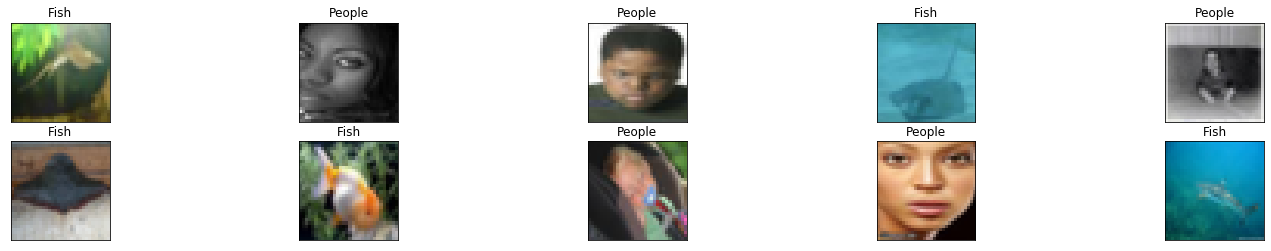

In [11]:
#randomly displaying images
fig=plt.figure(figsize=(25,4))
for i in range(1,11):
    ax=fig.add_subplot(2,5,i,xticks=[],yticks=[])
    index=np.random.randint(0,X_train.shape[0])
    ax.imshow(X_train[index],cmap='gray')
    ax.set_title("People" if y_train.iloc[index] else "Fish")

In [12]:
#preprocessing images
def prepocess_images(X):
    image_list=[]
    
    for x in X:
        image_list.append(preprocess_input(x))
        
    return np.array(image_list)

X_train=prepocess_images(X_train)
X_test=prepocess_images(X_test)

In [13]:
#loading VGG16 with imagenet weigths
image_size=32
num_class=2
model=VGG16(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [14]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [15]:
#get Feautre vectors from complete VGG16 network
X_train_features=model.predict(X_train).reshape(-1,512)
X_test_features=model.predict(X_test).reshape(-1,512)

In [16]:
#generate classification report
def generate_classification_report(predictions,y_test):
    report=pd.DataFrame.from_dict(classification_report(predictions,y_test,output_dict=True)).T
    report['Label']=[("People" if int(x) else "Fish") if x.isdigit() else " " for x in report.index]
    report=report[['Label','f1-score','precision','recall','support']]
    return report

In [17]:
#Training logistic regression  
lr=LogisticRegression()
lr.fit(X_train_features,y_train)
predictions=lr.predict(X_test_features)
print("Accuracy Score :",accuracy_score(predictions,y_test))
generate_classification_report(predictions,y_test)

C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy Score : 0.871


,Label,f1-score,precision,recall,support
0,Fish,0.871129,0.872000,0.870259,501.000
1,People,0.870871,0.870000,0.871743,499.000
accuracy,,0.871000,0.871000,0.871000,0.871
macro avg,,0.871000,0.871000,0.871001,1000.000
weighted avg,,0.871000,0.871002,0.871000,1000.000


In [18]:
#reducing the size of vgg16 network to extract low level features
reduced_model=Sequential()
for layer in model.layers[:-8]:
    reduced_model.add(layer)
reduced_model.add(Flatten())

In [19]:
reduced_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

In [20]:
#get Feautre vectors from complete VGG16 network
X_train_features=reduced_model.predict(X_train)
X_test_features=reduced_model.predict(X_test)

In [21]:
#Training logistic regression  
lr=LogisticRegression()
lr.fit(X_train_features,y_train)
predictions=lr.predict(X_test_features)
print("Accuracy Score :",accuracy_score(predictions,y_test))

C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy Score : 0.931


In [22]:
report=generate_classification_report(predictions,y_test)
report

,Label,f1-score,precision,recall,support
0,Fish,0.930931,0.930000,0.931864,499.000
1,People,0.931069,0.932000,0.930140,501.000
accuracy,,0.931000,0.931000,0.931000,0.931
macro avg,,0.931000,0.931000,0.931002,1000.000
weighted avg,,0.931000,0.931002,0.931000,1000.000
